# **최근접 이웃(K-Nearest Neighbor)**

* 데이터 포인트 간의 거리를 기준으로 가장 가까운 k개의 이웃을 찾아 분류 또는 회귀를 수행하는 비모수적(non-parametric) 알고리즘
* 매우 직관적이며, 새로운 데이터 포인트의 클래스나 값을 예측하기 위해 가장 가까운 이웃 데이터를 사용

## k 값의 선택
- **작은 k 값**: 모델이 복잡해지고 과적합(overfitting)될 수 있음
- **큰 k 값**: 모델이 단순해지며 과소적합(underfitting)될 위험이 있음
- 일반적으로 적절한 k 값을 찾기 위해 교차 검증(cross-validation)을 사용

![k nearest neighbor](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png)

### IRIS, WINE 데이터셋
* **데이터셋**: Iris (붓꽃 데이터) + Wine (와인 품질)
* **문제**: 다중 클래스 분류
* **알고리즘**: K-Nearest Neighbors

### 실습 목표
1. KNN의 작동 원리 이해 (거리 기반 분류)
2. k 값 선택의 중요성
3. 거리 척도 (Euclidean, Manhattan) 비교
4. Feature Scaling의 필요성
5. **심화**: 고차원 데이터 (WM-811K) 적용 시 고려사항

## 1. 라이브러리 Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, load_wine
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

## 2. Part 1: Iris Dataset (기본 이해)

### Iris 데이터셋
- 4개 특성: sepal length, sepal width, petal length, petal width
- 3개 클래스: setosa, versicolor, virginica
- 150개 샘플 (각 클래스 50개)

In [2]:
# Iris 데이터 로딩
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

print("=== Iris Dataset ===")
print(f"샘플 수: {X_iris.shape[0]}")
print(f"특성 수: {X_iris.shape[1]}")
print(f"클래스 수: {len(np.unique(y_iris))}")
print(f"\n특성 이름: {iris.feature_names}")
print(f"클래스 이름: {iris.target_names}")

# DataFrame으로 변환
df_iris = pd.DataFrame(X_iris, columns=iris.feature_names)
df_iris['species'] = iris.target_names[y_iris]
df_iris.head()

=== Iris Dataset ===
샘플 수: 150
특성 수: 4
클래스 수: 3

특성 이름: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
클래스 이름: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


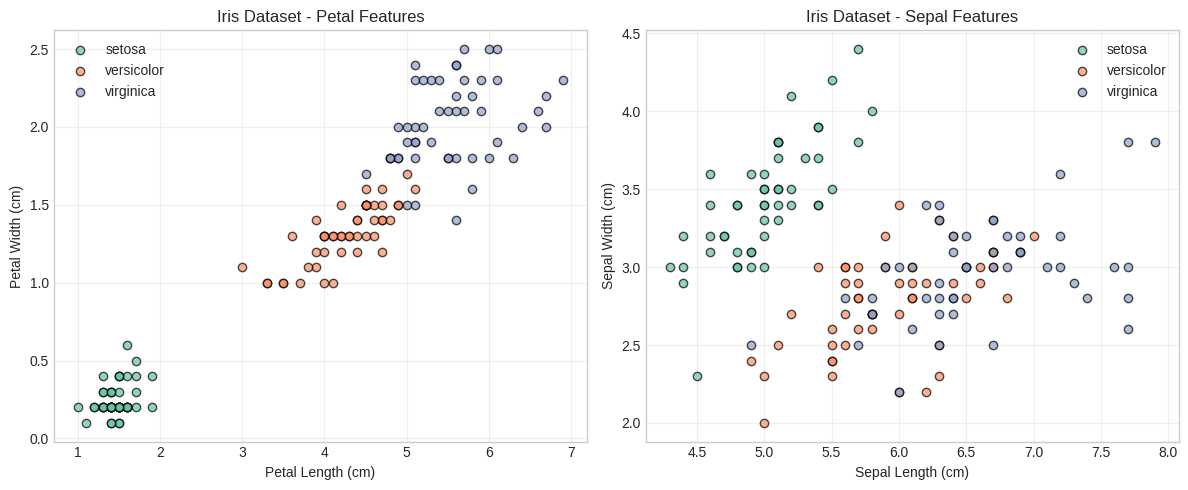

In [3]:
# 데이터 시각화 (2개 특성만 사용)
plt.figure(figsize=(12, 5))

# Petal Length vs Petal Width
plt.subplot(1, 2, 1)
for i, species in enumerate(iris.target_names):
    mask = y_iris == i
    plt.scatter(X_iris[mask, 2], X_iris[mask, 3], 
                label=species, alpha=0.7, edgecolors='k')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Iris Dataset - Petal Features')
plt.legend()
plt.grid(alpha=0.3)

# Sepal Length vs Sepal Width
plt.subplot(1, 2, 2)
for i, species in enumerate(iris.target_names):
    mask = y_iris == i
    plt.scatter(X_iris[mask, 0], X_iris[mask, 1], 
                label=species, alpha=0.7, edgecolors='k')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('Iris Dataset - Sepal Features')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. KNN 작동 원리

### KNN 알고리즘:
1. 테스트 샘플과 모든 훈련 샘플 간의 거리 계산
2. 가장 가까운 k개의 이웃 선택
3. k개 이웃 중 다수결로 클래스 결정

### 거리 척도:
- **Euclidean**: $d = \sqrt{\sum(x_i - y_i)^2}$
- **Manhattan**: $d = \sum|x_i - y_i|$
- **Minkowski**: $d = (\sum|x_i - y_i|^p)^{1/p}$

In [4]:
# Petal features만 사용하여 시각화 (이해하기 쉽게)
X_iris_2d = X_iris[:, [2, 3]]  # petal length, petal width

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_iris_2d, y_iris, test_size=0.3, random_state=42, stratify=y_iris
)

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Train samples: 105
Test samples: 45


In [5]:
# k=5인 KNN 모델
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"=== KNN (k=5) ===")
print(f"Test Accuracy: {acc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

=== KNN (k=5) ===
Test Accuracy: 0.9333

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



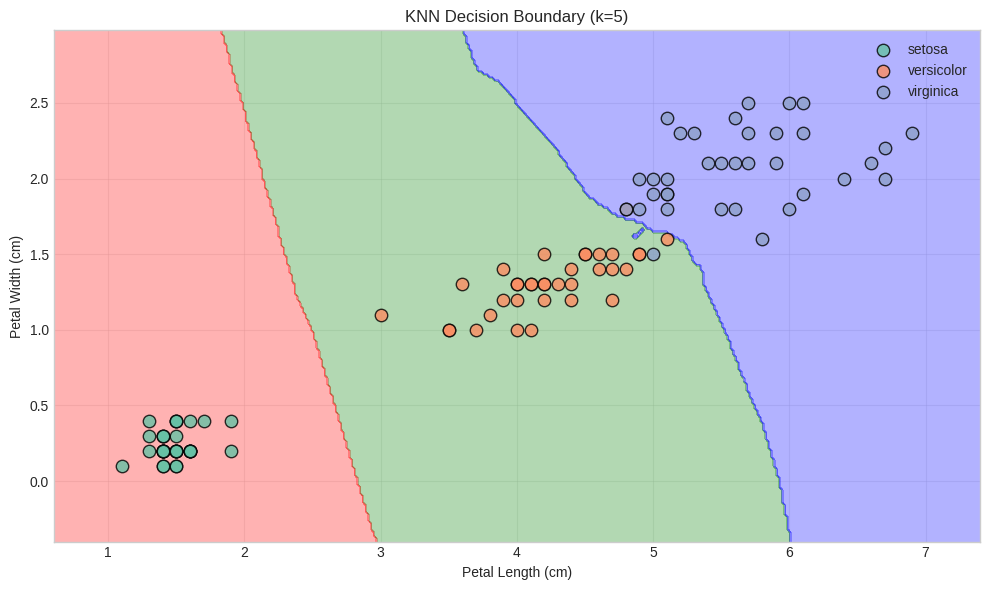

In [6]:
# Decision Boundary 시각화
def plot_decision_boundary(X, y, model, title="Decision Boundary"):
    h = 0.02  # step size
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['red', 'green', 'blue']))
    
    # Training data
    for i, species in enumerate(iris.target_names):
        mask = y == i
        plt.scatter(X[mask, 0], X[mask, 1], 
                   label=species, edgecolors='k', s=80, alpha=0.8)
    
    plt.xlabel('Petal Length (cm)')
    plt.ylabel('Petal Width (cm)')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_decision_boundary(X_train, y_train, knn, "KNN Decision Boundary (k=5)")

## 4. k 값 선택의 중요성

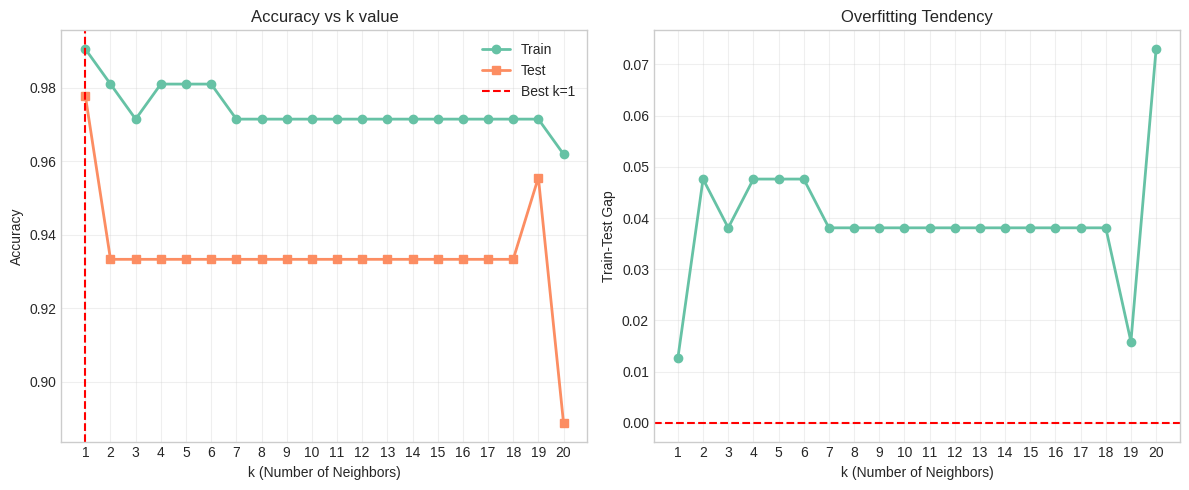

=== k 값 선택 결과 ===
Best k: 1
Best Test Accuracy: 0.9778

💡 k가 작으면: 과적합 위험 (복잡한 경계)
💡 k가 크면: 과소적합 위험 (단순한 경계)


In [7]:
# 다양한 k 값에 대한 성능 비교
k_values = range(1, 21)
train_scores = []
test_scores = []

for k in k_values:
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train, y_train)
    train_scores.append(knn_k.score(X_train, y_train))
    test_scores.append(knn_k.score(X_test, y_test))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, train_scores, 'o-', label='Train', linewidth=2)
plt.plot(k_values, test_scores, 's-', label='Test', linewidth=2)
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k value')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(k_values)

# Best k 찾기
best_k = k_values[np.argmax(test_scores)]
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.legend()

# Overfitting/Underfitting 설명
plt.subplot(1, 2, 2)
plt.plot(k_values, np.array(train_scores) - np.array(test_scores), 'o-', linewidth=2)
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Train-Test Gap')
plt.title('Overfitting Tendency')
plt.grid(alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(k_values)

plt.tight_layout()
plt.show()

print(f"=== k 값 선택 결과 ===")
print(f"Best k: {best_k}")
print(f"Best Test Accuracy: {max(test_scores):.4f}")
print(f"\n💡 k가 작으면: 과적합 위험 (복잡한 경계)")
print(f"💡 k가 크면: 과소적합 위험 (단순한 경계)")

## 5. Feature Scaling의 중요성

In [8]:
# 4개 특성 모두 사용 (scaling 전후 비교)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42, stratify=y_iris
)

# Scaling 전
knn_no_scale = KNeighborsClassifier(n_neighbors=5)
knn_no_scale.fit(X_train_full, y_train_full)
acc_no_scale = knn_no_scale.score(X_test_full, y_test_full)

# Scaling 후
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train_full)
acc_scaled = knn_scaled.score(X_test_scaled, y_test_full)

print("=== Feature Scaling 효과 ===")
print(f"Scaling 전: {acc_no_scale:.4f}")
print(f"Scaling 후: {acc_scaled:.4f}")
print(f"개선도: {(acc_scaled - acc_no_scale):.4f}")

# 특성별 스케일 비교
print(f"\n=== 특성별 스케일 (Scaling 전) ===")
for i, name in enumerate(iris.feature_names):
    print(f"{name}: mean={X_train_full[:, i].mean():.2f}, std={X_train_full[:, i].std():.2f}")

print(f"\n💡 KNN은 거리 기반이므로 Scaling이 필수!")

=== Feature Scaling 효과 ===
Scaling 전: 0.9778
Scaling 후: 0.9111
개선도: -0.0667

=== 특성별 스케일 (Scaling 전) ===
sepal length (cm): mean=5.87, std=0.86
sepal width (cm): mean=3.06, std=0.46
petal length (cm): mean=3.78, std=1.78
petal width (cm): mean=1.21, std=0.77

💡 KNN은 거리 기반이므로 Scaling이 필수!


## 6. 거리 척도 비교

Euclidean: 0.9111
Manhattan: 0.9111
Minkowski: 0.9111


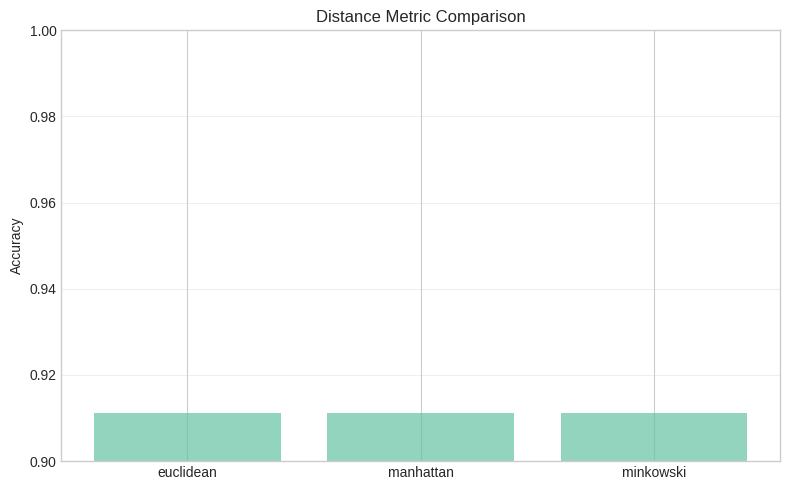

In [9]:
# 다양한 거리 척도 비교
metrics = ['euclidean', 'manhattan', 'minkowski']
metric_scores = {}

for metric in metrics:
    knn_metric = KNeighborsClassifier(n_neighbors=5, metric=metric)
    knn_metric.fit(X_train_scaled, y_train_full)
    score = knn_metric.score(X_test_scaled, y_test_full)
    metric_scores[metric] = score
    print(f"{metric.capitalize()}: {score:.4f}")

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(metric_scores.keys(), metric_scores.values(), alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Distance Metric Comparison')
plt.ylim([0.9, 1.0])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Part 2: Wine Dataset (좀 더 복잡한 예제)

In [10]:
# Wine 데이터 로딩
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

print("=== Wine Dataset ===")
print(f"샘플 수: {X_wine.shape[0]}")
print(f"특성 수: {X_wine.shape[1]}")
print(f"클래스 수: {len(np.unique(y_wine))}")
print(f"\n클래스 분포:")
for i, name in enumerate(wine.target_names):
    print(f"  {name}: {(y_wine == i).sum()}개")

=== Wine Dataset ===
샘플 수: 178
특성 수: 13
클래스 수: 3

클래스 분포:
  class_0: 59개
  class_1: 71개
  class_2: 48개


In [11]:
# Wine 데이터 전처리 및 학습
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
    X_wine, y_wine, test_size=0.3, random_state=42, stratify=y_wine
)

# Scaling
scaler_wine = StandardScaler()
X_train_wine_scaled = scaler_wine.fit_transform(X_train_wine)
X_test_wine_scaled = scaler_wine.transform(X_test_wine)

# GridSearchCV로 최적 하이퍼파라미터 찾기
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

print("GridSearchCV 실행 중...")
grid_search.fit(X_train_wine_scaled, y_train_wine)

print(f"\n=== GridSearchCV Results ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")
print(f"Test Accuracy: {grid_search.score(X_test_wine_scaled, y_test_wine):.4f}")

GridSearchCV 실행 중...

=== GridSearchCV Results ===
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Best CV Accuracy: 0.9757
Test Accuracy: 0.9630


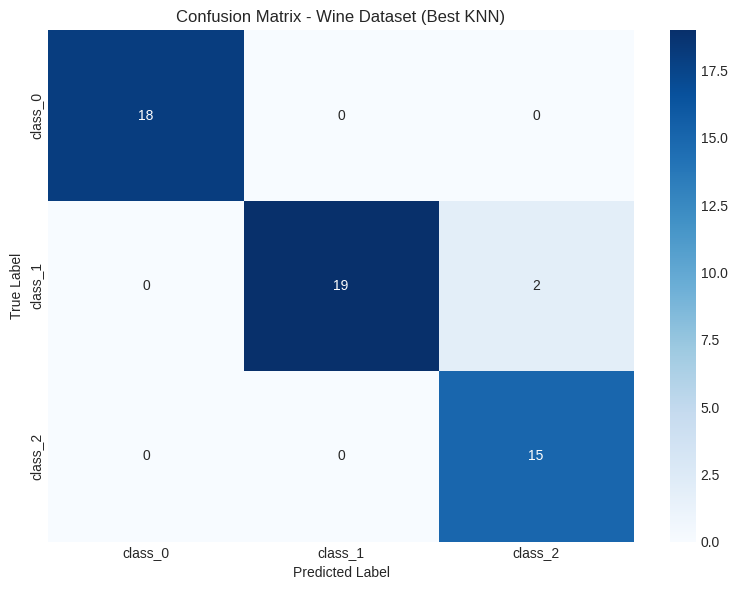

Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       1.00      0.90      0.95        21
     class_2       0.88      1.00      0.94        15

    accuracy                           0.96        54
   macro avg       0.96      0.97      0.96        54
weighted avg       0.97      0.96      0.96        54



In [12]:
# Confusion Matrix
best_knn = grid_search.best_estimator_
y_pred_wine = best_knn.predict(X_test_wine_scaled)

cm = confusion_matrix(y_test_wine, y_pred_wine)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=wine.target_names,
            yticklabels=wine.target_names)
plt.title('Confusion Matrix - Wine Dataset (Best KNN)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("Classification Report:")
print(classification_report(y_test_wine, y_pred_wine, target_names=wine.target_names))

## 8. 심화: 고차원 데이터에서의 KNN

### 차원의 저주 (Curse of Dimensionality)
- 고차원 공간에서는 모든 점이 비슷한 거리에 위치
- KNN의 성능 저하

### 해결책:
1. **Feature Engineering**: 수작업 특성 추출 (10차원 이하로 축소)
2. **차원 축소**: PCA, t-SNE 사용
3. **다른 알고리즘 사용**: CNN (이미지 데이터에 최적)

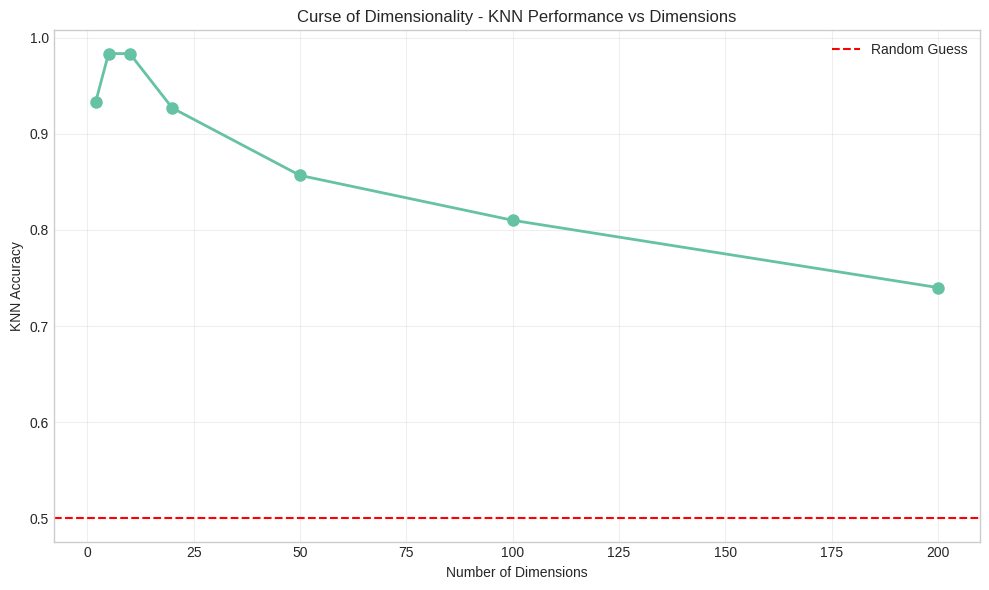

=== 차원의 저주 효과 ===
차원 수   2: Accuracy 0.9333
차원 수   5: Accuracy 0.9833
차원 수  10: Accuracy 0.9833
차원 수  20: Accuracy 0.9267
차원 수  50: Accuracy 0.8567
차원 수 100: Accuracy 0.8100
차원 수 200: Accuracy 0.7400

💡 차원이 증가하면 KNN 성능이 감소합니다!


In [13]:
# 차원의 저주 시뮬레이션
from sklearn.datasets import make_classification

dimensions = [2, 5, 10, 20, 50, 100, 200]
knn_scores = []

for dim in dimensions:
    # 랜덤 데이터 생성
    X, y = make_classification(n_samples=1000, n_features=dim, 
                               n_informative=min(dim, 10), n_redundant=0,
                               n_clusters_per_class=1, random_state=42)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)
    score = knn.score(X_test_scaled, y_test)
    knn_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(dimensions, knn_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Dimensions')
plt.ylabel('KNN Accuracy')
plt.title('Curse of Dimensionality - KNN Performance vs Dimensions')
plt.grid(alpha=0.3)
plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guess')
plt.legend()
plt.tight_layout()
plt.show()

print("=== 차원의 저주 효과 ===")
for dim, score in zip(dimensions, knn_scores):
    print(f"차원 수 {dim:3d}: Accuracy {score:.4f}")

print("\n💡 차원이 증가하면 KNN 성능이 감소합니다!")

## 9. KNN의 장단점

### 장점:
- ✅ 직관적이고 이해하기 쉬움
- ✅ 학습 과정이 빠름 (Lazy Learning)
- ✅ 비선형 분류 가능
- ✅ 새로운 데이터 추가가 쉬움

### 단점:
- ❌ 예측 속도가 느림 (O(N) - 모든 샘플과 거리 계산)
- ❌ 메모리 사용량이 큼 (모든 훈련 데이터 저장)
- ❌ 차원의 저주에 취약
- ❌ Feature Scaling 필수
- ❌ 불균형 데이터에 약함

### 사용 권장 상황:
- 저차원 데이터 (특성 < 20)
- 중소규모 데이터셋 (샘플 < 10,000)
- 비선형 패턴이 있는 경우
- 빠른 프로토타이핑

## 10. 결론 및 요약

In [ ]:
# 최종 성능 요약
summary = pd.DataFrame({
    'Dataset': ['Iris (2 features)', 'Iris (4 features, no scaling)', 
                'Iris (4 features, scaled)', 'Wine (scaled + tuned)'],
    'Accuracy': [acc, acc_no_scale, acc_scaled, 
                 grid_search.score(X_test_wine_scaled, y_test_wine)],
    'Note': ['Petal features only', 'All features', 'Best practice', 'Optimized']
})

print("=== KNN 성능 요약 ===")
print(summary.to_string(index=False))

print("\n💡 핵심 포인트:")
print("  1. k 값 선택이 중요 (GridSearchCV 활용)")
print("  2. Feature Scaling 필수 (StandardScaler)")
print("  3. 저차원 데이터에 적합")
print("  4. 고차원 이미지 데이터는 Feature Engineering 필요")
print("  5. 실시간 예측이 필요하면 다른 알고리즘 고려")

=== KNN 성능 요약 ===
                      Dataset  Accuracy                Note
            Iris (2 features)  0.933333 Petal features only
Iris (4 features, no scaling)  0.977778        All features
    Iris (4 features, scaled)  0.911111       Best practice
        Wine (scaled + tuned)  0.962963           Optimized

✓ KNN Classification 실습 완료!

💡 핵심 포인트:
  1. k 값 선택이 중요 (GridSearchCV 활용)
  2. Feature Scaling 필수 (StandardScaler)
  3. 저차원 데이터에 적합
  4. 고차원 이미지 데이터는 Feature Engineering 필요
  5. 실시간 예측이 필요하면 다른 알고리즘 고려
